In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
stock = pd.read_csv("data/stock.csv",parse_dates=True, index_col=0)

In [3]:
stock_3 = stock[["AAPL", "MSFT", "XOM"]]

In [4]:
stock_3 = stock_3.resample("B").ffill()

In [5]:
stock_3

,AAPL,MSFT,XOM
2003-01-02,7.40,21.11,29.22
2003-01-03,7.45,21.14,29.24
2003-01-06,7.45,21.52,29.96
2003-01-07,7.43,21.93,28.95
2003-01-08,7.28,21.31,28.83
...,...,...,...
2011-10-10,388.81,26.94,76.28
2011-10-11,400.29,27.00,76.27
2011-10-12,402.19,26.96,77.16
2011-10-13,408.43,27.18,76.37


# 1.指数加权函数ewm:

### 下面将 苹果公司 股价的 30 天日均线与span = 30 的指数加权 (EW) 移动平均线进行比较：

In [6]:
aapl_px = stock_3["AAPL"]["2006":"2007"]
aapl_px

2006-01-02     71.89
2006-01-03     74.75
2006-01-04     74.97
2006-01-05     74.38
2006-01-06     76.30
               ...  
2007-12-25    198.80
2007-12-26    198.95
2007-12-27    198.57
2007-12-28    199.83
2007-12-31    198.08
Freq: B, Name: AAPL, Length: 521, dtype: float64

In [7]:
ma30 = aapl_px.rolling(30, min_periods=20).mean()
ma30

2006-01-02           NaN
2006-01-03           NaN
2006-01-04           NaN
2006-01-05           NaN
2006-01-06           NaN
                 ...    
2007-12-25    181.520333
2007-12-26    182.615000
2007-12-27    183.757333
2007-12-28    184.872000
2007-12-31    186.009667
Freq: B, Name: AAPL, Length: 521, dtype: float64

In [8]:
ewma30 = aapl_px.ewm(span=30).mean()
ewma30

2006-01-02     71.890000
2006-01-03     73.367667
2006-01-04     73.937767
2006-01-05     74.059619
2006-01-06     74.569360
                 ...    
2007-12-25    184.441771
2007-12-26    185.377786
2007-12-27    186.228897
2007-12-28    187.106387
2007-12-31    187.814362
Freq: B, Name: AAPL, Length: 521, dtype: float64

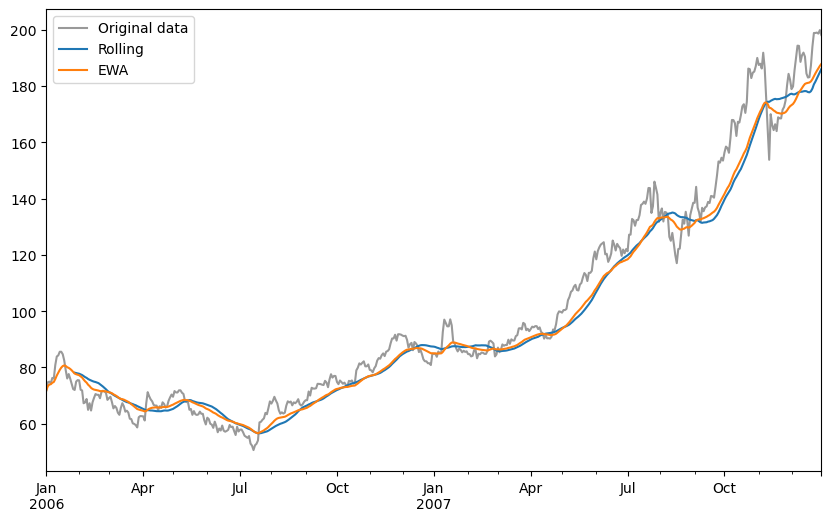

In [9]:
aapl_px.plot(style="k-", alpha=0.4 ,label="Original data" , figsize=(10,6))

ma30.plot(style="-", label="Rolling")

ewma30.plot(style="-", label="EWA")

plt.legend() # 创建图例

# 2.二元移动窗口函数：

### 例如，金融分析师通常对股票与标准普尔 500 指数等基准指数的相关性感兴趣。为了了解这一点，我们首先计算我们感兴趣的所有时间序列的百分比变化：

In [10]:
spx_px = stock["SPX"]
spx_px

2003-01-02     909.03
2003-01-03     908.59
2003-01-06     929.01
2003-01-07     922.93
2003-01-08     909.93
               ...   
2011-10-10    1194.89
2011-10-11    1195.54
2011-10-12    1207.25
2011-10-13    1203.66
2011-10-14    1224.58
Name: SPX, Length: 2214, dtype: float64

In [11]:
spx_rets = spx_px.pct_change()
spx_rets

2003-01-02         NaN
2003-01-03   -0.000484
2003-01-06    0.022474
2003-01-07   -0.006545
2003-01-08   -0.014086
                ...   
2011-10-10    0.034125
2011-10-11    0.000544
2011-10-12    0.009795
2011-10-13   -0.002974
2011-10-14    0.017380
Name: SPX, Length: 2214, dtype: float64

In [12]:
returns = stock_3.pct_change()
returns

,AAPL,MSFT,XOM
2003-01-02,NaN,NaN,NaN
2003-01-03,0.006757,0.001421,0.000684
2003-01-06,0.000000,0.017975,0.024624
2003-01-07,-0.002685,0.019052,-0.033712
2003-01-08,-0.020188,-0.028272,-0.004145
...,...,...,...
2011-10-10,0.051406,0.026286,0.036977
2011-10-11,0.029526,0.002227,-0.000131
2011-10-12,0.004747,-0.001481,0.011669
2011-10-13,0.015515,0.008160,-0.010238


### 在我们调用rolling之后，corr 聚合函数可以根据 spx_rets 计算滚动相关性：

<AxesSubplot:>

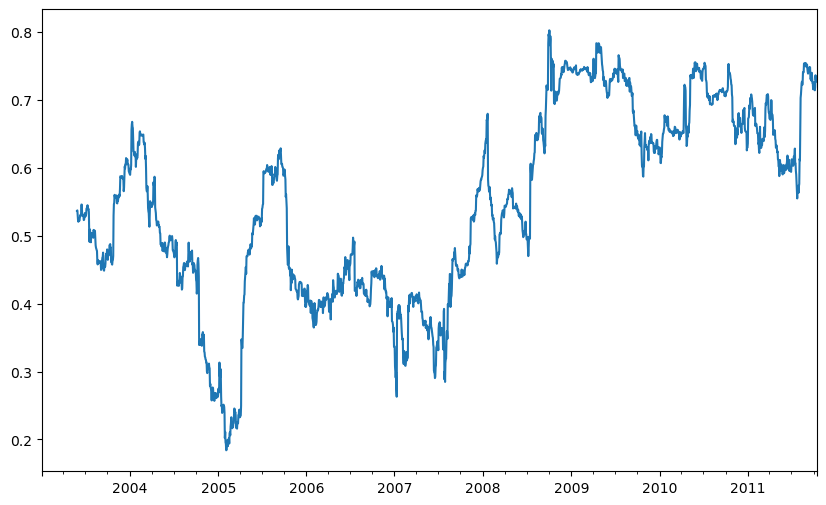

In [13]:
corr = returns["AAPL"].rolling(125, min_periods=100).corr(spx_rets)

corr.plot(figsize=(10,6))

### 假设您想同时计算标准普尔 500 指数与多只股票的滚动相关性。您可以像上面所做的那样为每只股票编写一个循环来计算它，但是如果每只股票都是单个 DataFrame 中的一列，我们可以通过在 DataFrame 上调用rolling 并传递 spx_rets 来一次计算所有滚动相关性。

<AxesSubplot:>

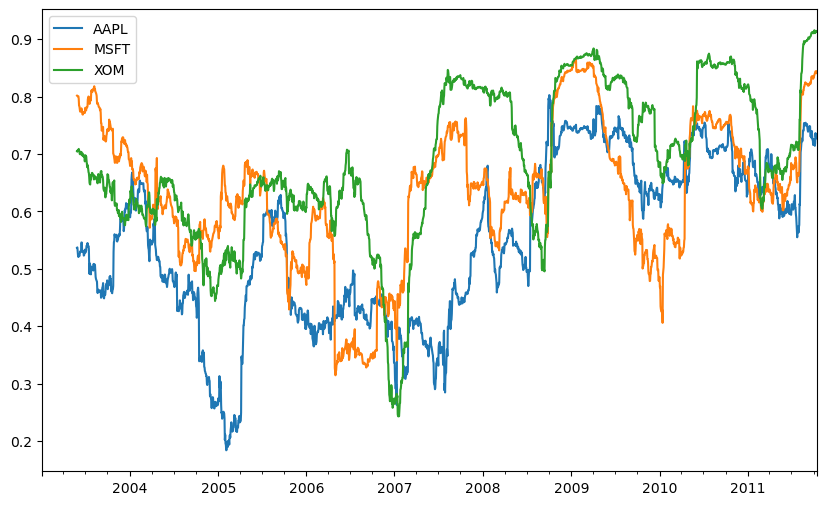

In [14]:
corr = returns.rolling(125, min_periods=100).corr(spx_rets)

corr.plot(figsize=(10,6))

# 3.用户定义的移动窗口函数：

### 例如，尽管我们可以使用rolling(...).quantile(q) 计算样本的分位数，但是我们可能对特定值在样本中的百分位数感兴趣。scipy.stats.percentileofscore 函数就是实现该功能的：

In [15]:
# 如果您还没有安装 SciPy，您可以使用 conda 或 pip 安装它：conda install scipy
from scipy.stats import percentileofscore

In [16]:
def score_at_2percent(x):
    return percentileofscore(x, 0.02)

In [17]:
result = returns["AAPL"].rolling(250).apply(score_at_2percent)
result

2003-01-02     NaN
2003-01-03     NaN
2003-01-06     NaN
2003-01-07     NaN
2003-01-08     NaN
              ... 
2011-10-10    92.4
2011-10-11    92.0
2011-10-12    92.0
2011-10-13    92.0
2011-10-14    91.6
Freq: B, Name: AAPL, Length: 2292, dtype: float64

<AxesSubplot:>

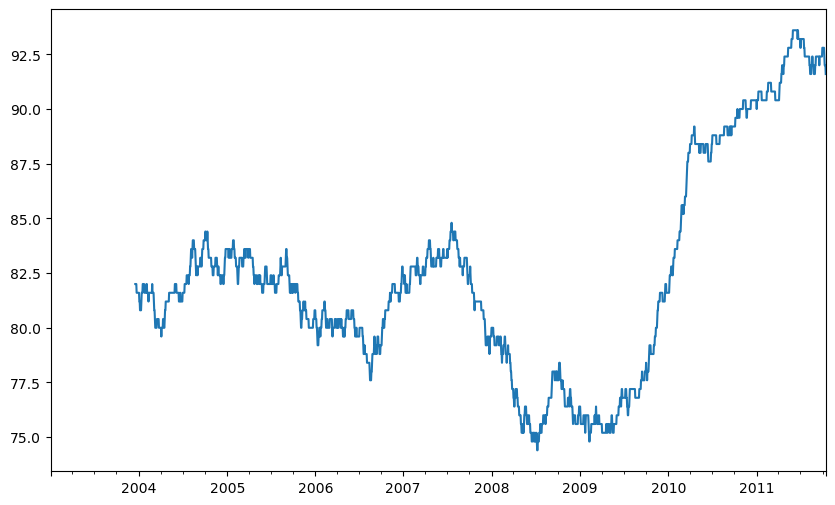

In [18]:
result.plot(figsize=(10,6))